# Does the BGC argo data give evidence for a subsurface chlorophyll maximum?

- We want to know the role of biological uptake in SO carbon cycling. 
- Satellite data sees only the very surface and has limited coverage towards the poles.
- In theory, the BGC argo floats could tell us a bit about what is going on below the surface.

However estimating in-situ chlorophyll from fluorescence is HARD, especially in the SO, because of things like nonphotochemical quenching, etc, different reactions of photosynthesis to iron limitation, etc. *I don't really know what I am doing* when looking at these data, but I am doing a short analysis based on the parameter CHLA_ADJUSTED, consideringn only QC == 1, good data. All data with QC == 1 are binned to model grid and aveeraged. 

- Here I'm going to use the BGC argo profiles to look below the surface using the fluorescence ChlA
 
The data is a synthesis product that comes from here:
https://www.seanoe.org/data/00311/42182/

{BGC Sprof data files (2022-10-08 snapshot)}

# NPQ background caveats and notes (Baldry et al 2020):

*In situ fluorometers measure chlorophyll fluorescence from live phytoplankton cells. As measurements are not performed ex situ on extracted pigments, yields of chlorophyll fluorescence (i.e., the ratio of emitted light to absorbed light) become important by controlling fluorescence to chlorophyll-a concentration ratios (Falkowski and Kolber, 1995; Chekalyuk and Hafez, 2011; Ostrowska et al., 2012). Shifts in phytoplankton communities, photophysiological state or nutrient regimes lead to variations in chlorophyll fluorescence yields of up to 7-fold over the global ocean (Behrenfeld et al., 2009; Cheah et al., 2013; Roesler et al., 2017). In addition, a physiological process whereby phytoplankton under light stress divert energy from their photosynthetic systems, called non-photochemical quenching (NPQ), introduces a further challenge for determining chlorophyll-a concentration by decreasing chlorophyll fluorescence yield by up to 100% in surface measurements (Behrenfeld et al., 2009; Doblin et al., 2011; Thomalla et al., 2018; Xing et al., 2018; Schallenberg et al., 2019).*

*Correcting fluorescence-derived chlorophyll-a in the Southern Ocean for observed variations in chlorophyll fluorescence yields is done by applying a regional scaling known as the Roesler factor (Haëntjens et al., 2017; Roesler et al., 2017). The application of a single scaling factor to the entire Southern Ocean does not seem viable considering the recent observations from Schallenberg et al. (2019) which show large changes in chlorophyll fluorescence yields across the Sub-Antarctic front. The use of satellite-derived chlorophyll-a as a surface reference to correct fluorescence-derived chlorophyll-a may be a more promising approach, although consideration that the two measurements are made on vastly different spatiotemporal scales is needed (Guinet et al., 2013). This approach comes possibly at the expense of accuracy, as the accuracy of Southern Ocean satellite-derived chlorophyll-a algorithms has repeatedly been questioned (Figure 3; Mitchell and Holm-Hansen, 1991; Sullivan et al., 1993; Dierssen, 2010; Johnson et al., 2013).*

In [29]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [30]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [31]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

    -- Load data, make list of those that have CHLA data and latitudes <-30N
    -- Visualize temporal coverage

In [32]:
sset = ['coriolis','kma','csiro','bodc', 'nmdis', 'incois', 'aoml', 'meds', 'csio', 'kordi', 'jma']

In [33]:
horse = False
if horse:
    i = 0
    with_chl = []
    for i in range(0,len(sset)):
        w = glob.glob(f'/gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/{sset[i]}/*.nc')
        print(len(w))
        for r in range(0,len(w)):
            tw = xr.open_dataset(w[r])
            if 'CHLA' in tw.keys():
                with_chl.append(w[r])
    pickle.dump(with_chl, open("./pkls/BGCwithCHL.pkl", 'wb'))


In [34]:
if horse:
    BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))
    BGC_solist = []
    for i in range(0,len(BGClist)):

        tw = xr.open_dataset(BGClist[i])
        q =(np.min(tw['LATITUDE']))
        if q <= -30:
            BGC_solist.append(BGClist[i])

    pickle.dump(BGC_solist, open("./pkls/BGCwithCHL_SO.pkl", 'wb'))

In [35]:
BGClist = pickle.load(open('./pkls/BGCwithCHL_SO.pkl', 'rb'))
print(np.shape(BGClist))

(288,)


Text(0.5, 0, 'profile no.')

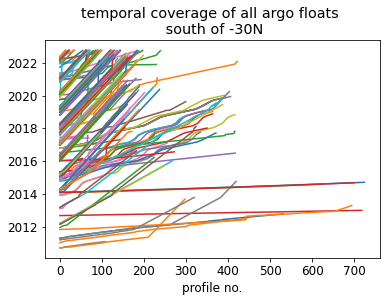

In [36]:

np.shape(BGClist)

plt.figure()
for i in range(0,len(BGClist)):
    w = xr.open_dataset(BGClist[i])
    plt.plot(w['JULD'])
plt.title('temporal coverage of all argo floats \n south of -30N')
plt.xlabel('profile no.')

In [37]:
##TJSJ 

tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['gdept_1d'][0,:]

def getlev(tar):
    
    ### get boundaries/bottomes:
    tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    e3t = (tmesh['e3t_0'][0,:,104,24])
    e3tbot = np.zeros_like(e3t)
    for i in range(0,31):
        e3tbot[i] = np.nansum(e3t[0:i+1])
    
    ### get good levels
    tlev = np.zeros_like(tar)
    tlev[tlev<e3tbot[0]] = 0
    for i in range(1,31):
        tlev[(tar>=(e3tbot[i-1])) & (tar < e3tbot[i])] = i
    tlev[tar>5000] = 30
    tlev[tlev == 0] = np.nan
    
    return tlev
        
def getchl(chl, tlev):
    tchl = np.zeros([31])
    for i in range(0,31):
        tchl[i] = np.nanmean(chl[tlev == i])
    tchl[tchl == 0] = np.nan
    
    return tchl

    -- clean data and bin to model grid for future use
    -- interpolation via scipy gives weird results bc of poor polynomial fit with outliers, so I binned for first-look:
    -- For each float, for each profile, create a model-sized profile (ie 31 model grid depths):
        -- take only data (CHL_ADJUSTED, see docs for processing details) with QF == 1, find what model depth bin it's in and assign
        -- average all obs in each depth bin and use average for the value in the cleaned profile
    -- save cleaned floats in individual ncs, for uniqueness, profile numbers are of form {float_number}.{profile_number/1000}
    -- combine individual ncs into a single dataset for ease of use
    
Notes: no valid CHLA_adju data in top 10m, anywhere? (could be because of NPQ, method may assume that you can't get good in-situ chl. fl. data in such high light conditions?

In [38]:
if horse:
    for d in range(0, 1):

        w = xr.open_dataset(BGClist[d])

        tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
        tplat = int(tplat[0])
        testnam = f'{w.institution}_{tplat}.nc'
        print(f'{d} {testnam}')
        nprof = len(w['N_PROF'].values)

        lats = np.zeros([nprof,31])
        lons = np.zeros([nprof,31])
        mons = np.zeros([nprof,31])
        yrs = np.zeros([nprof,31])
        chla_adj = np.zeros([nprof,31])
        tprof = np.zeros([nprof])
        Y = np.zeros([nprof,31])
        X = np.zeros([nprof,31])

        i = 10

        tprof[i] = tplat +(i/1000)
        chlqc = w['CHLA_ADJUSTED_QC'][i,:].values.astype(float)
        if (np.isnan(chlqc).all()):
            lats[i,:]= np.nan
            lons[i,:]= np.nan
            mons[i,:]= np.nan
            yrs[i,:] = np.nan
            X[i,:] = np.nan
            Y[i,:] = np.nan
            chla_adj[i,:] = np.nan

        else:
            lats[i,:] = w['LATITUDE'][i].values.astype(float)
            lons[i,:] = w['LONGITUDE'][i].values.astype(float)
            juld = w['JULD'][i].values
            mons[i,:] = juld.astype('datetime64[M]').astype(int)% 12 + 1
            yrs[i,:] = juld.astype('datetime64[Y]').astype(int) + 1970
            tY, tX = ut.find_closest(w['LONGITUDE'][i].values.astype(float), w['LATITUDE'][i].values.astype(float))
            X[i,:] = tX
            Y[i,:] = tY
            tar = w['PRES'][i,:].values
            print(tar[0:100])
            chl = w['CHLA_ADJUSTED'][i,:].values.astype(float)
            print(chl[0:100])
            chlqc = w['CHLA_ADJUSTED_QC'][i,:].values.astype(float)
            print(chlqc[0:100])
            chl[chlqc != 1.] = np.nan 
            print(chl[0:100])
            tlev = getlev(tar)
            chla_adj[i,:] = getchl(chl,tlev)

In [39]:

tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['gdept_1d'][0,:]
if horse:
    for d in range(0, len(BGClist)):

        w = xr.open_dataset(BGClist[d])

        tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
        tplat = int(tplat[0])
        testnam = f'{w.institution}_{tplat}.nc'
        print(f'{d} {testnam}')
        nprof = len(w['N_PROF'].values)

        lats = np.zeros([nprof,31])
        lons = np.zeros([nprof,31])
        mons = np.zeros([nprof,31])
        yrs = np.zeros([nprof,31])
        chla_adj = np.zeros([nprof,31])
        tprof = np.zeros([nprof])
        Y = np.zeros([nprof,31])
        X = np.zeros([nprof,31])

        for i in range(0,nprof):

            tprof[i] = tplat +(i/1000)
            chlqc = w['CHLA_ADJUSTED_QC'][i,:].values.astype(float)
            if (np.isnan(chlqc).all()):
                lats[i,:]= np.nan
                lons[i,:]= np.nan
                mons[i,:]= np.nan
                yrs[i,:] = np.nan
                X[i,:] = np.nan
                Y[i,:] = np.nan
                chla_adj[i,:] = np.nan

            else:
                lats[i,:] = w['LATITUDE'][i].values.astype(float)
                lons[i,:] = w['LONGITUDE'][i].values.astype(float)
                juld = w['JULD'][i].values
                mons[i,:] = juld.astype('datetime64[M]').astype(int)% 12 + 1
                yrs[i,:] = juld.astype('datetime64[Y]').astype(int) + 1970
                tY, tX = ut.find_closest(w['LONGITUDE'][i].values.astype(float), w['LATITUDE'][i].values.astype(float))
                X[i,:] = tX
                Y[i,:] = tY
                tar = w['PRES'][i,:].values
                chl = w['CHLA_ADJUSTED'][i,:].values.astype(float)
                chlqc = w['CHLA_ADJUSTED_QC'][i,:].values.astype(float)
                chl[chlqc != 1.] = np.nan 
                tlev = getlev(tar)
                chla_adj[i,:] = getchl(chl,tlev)


        data_vars = {'chla_adj':(['profno', 'depth'], chla_adj,
                         {'units': 'mg/m3'}),
                     'lat':(['profno', 'depth'], lats,
                         {'units': ''}),
                     'lon':(['profno', 'depth'], lons,
                         {'units': ''}),
                     'month':(['profno', 'depth'], mons,
                         {'units': ''}),
                     'year':(['profno', 'depth'], yrs,
                         {'units': ''}),
                     'X':(['profno', 'depth'], X,
                         {'units': ''}),
                     'Y':(['profno', 'depth'], Y,
                         {'units': ''}),

                    }

        # define coordinates
        coords = {'profno': (['profno'], tprof),
                  'depth': (['depth'], tmask)

                 }

        # define global attributes
        attrs = {'institution':w.institution,
                 'madein':'evalOutput/BGC_Argo_explore.ipynb'}

        # create dataset
        tds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        tds.to_netcdf(f'./argo_processed/{testnam}')


In [40]:
if horse:
    nprof = 41483

    lats = np.zeros([nprof,31])
    lons = np.zeros([nprof,31])
    mons = np.zeros([nprof,31])
    yrs = np.zeros([nprof,31])
    chla_adj = np.zeros([nprof,31])
    tprof = np.zeros([nprof])
    Y = np.zeros([nprof,31])
    X = np.zeros([nprof,31])

    w = glob.glob('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/argo_processed/*.nc')
    count = 0
    for i in range(0,len(w)):
        #print(f'{i}, {count}')
        ds2 = xr.open_mfdataset(w[i])
        tprf = (len(ds2.profno))

        lats[count:count+tprf,:] = ds2['lat'][:].values
        lons[count:count+tprf,:]  = ds2['lon'][:].values
        mons[count:count+tprf,:]  = ds2['month'][:].values
        yrs[count:count+tprf,:]  = ds2['year'][:].values
        chla_adj[count:count+tprf,:] = ds2['chla_adj'][:].values
        tprof[count:count+tprf]  = ds2['profno'][:].values
        Y[count:count+tprf,:] = ds2['Y'][:].values
        X[count:count+tprf,:]  = ds2['X'][:].values

        count = count+tprf

    data_vars = {'chla_adj':(['profno', 'depth'], chla_adj,
                     {'units': 'mg/m3'}),
                 'lat':(['profno', 'depth'], lats,
                     {'units': ''}),
                 'lon':(['profno', 'depth'], lons,
                     {'units': ''}),
                 'month':(['profno', 'depth'], mons,
                     {'units': ''}),
                 'year':(['profno', 'depth'], yrs,
                     {'units': ''}),
                 'X':(['profno', 'depth'], X,
                     {'units': ''}),
                 'Y':(['profno', 'depth'], Y,
                     {'units': ''}),

                }

    # define coordinates
    coords = {'profno': (['profno'], tprof),
              'depth': (['depth'], tmask)

             }

    # define global attributes
    attrs = {'madein':'evalOutput/BGC_Argo_explore.ipynb'}

    # create dataset
    tds = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)

    tds.to_netcdf(f'SO_merged_argo.nc')

In [41]:
def scatter_southern(fig, ax1, lons, lats, tdat, tvmin, dotsize,
                  tvmax, tticks, northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -30], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    #lons = nav_lon[0:37,:]; lats = nav_lat[0:37,:]; 
    mesh = ax1.scatter(lons, lats, s = dotsize, c = tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))
    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = fs)
        cb.set_ticks(tticks, fontsize = 105)
        cb.ax.tick_params(labelsize=16)
    return cb

In [42]:
w = xr.open_dataset(f'./SO_merged_argo.nc')
tlat = w['lat'][:,0].values
tlon = w['lon'][:,0].values
surf_month = w['month'][:,0].values

print(np.max(surf_month))

nan


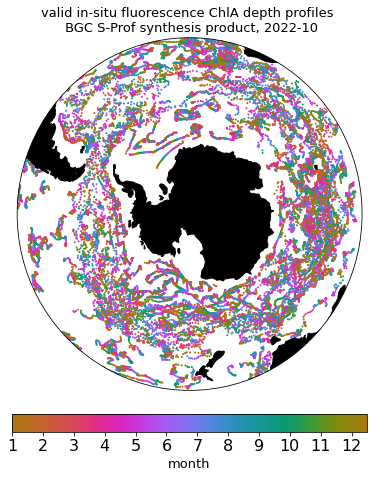

In [43]:

w = xr.open_dataset(f'./SO_merged_argo.nc')
tlat = w['lat'][:,0].values
tlon = w['lon'][:,0].values
surf_month = w['month'][:,0].values

fact = 0.5
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax1 = tfig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, -90))
lons = tlon
lats = tlat
tdat = surf_month
tvmin = 1
tvmax = 12.5
tticks = np.arange(1,13,1)
dotsize = 1
scatter_southern(tfig, ax1, lons, lats, tdat, tvmin, dotsize,
                  tvmax, tticks, northex = -50, fs = 13, 
                  tit = 'valid in-situ fluorescence ChlA depth profiles \n BGC S-Prof synthesis product, 2022-10', cbarlab = 'month', tcmap = cm.phase, lm = True, cbr = True)

In [44]:
tlat = w['lat'][:].values
tlon = w['lon'][:].values
tchla_adj = w['chla_adj'][:].values
tmonth = w['month'][:].values

# count = 0
# for i in range(1,13):
#     tfilt = (tmonth[:,0] == i)

#     q =(np.shape(tchla_adj[tfilt,:])[0])
#     count = count+q
# print(np.shape(tmonth[:,0][np.isnan(tmonth[:,0])]))
# print(count)
# print(np.min(tmonth))
# print(np.shape(tmonth))

# Crudely, plotting all available depth profiles by month, lat < -30

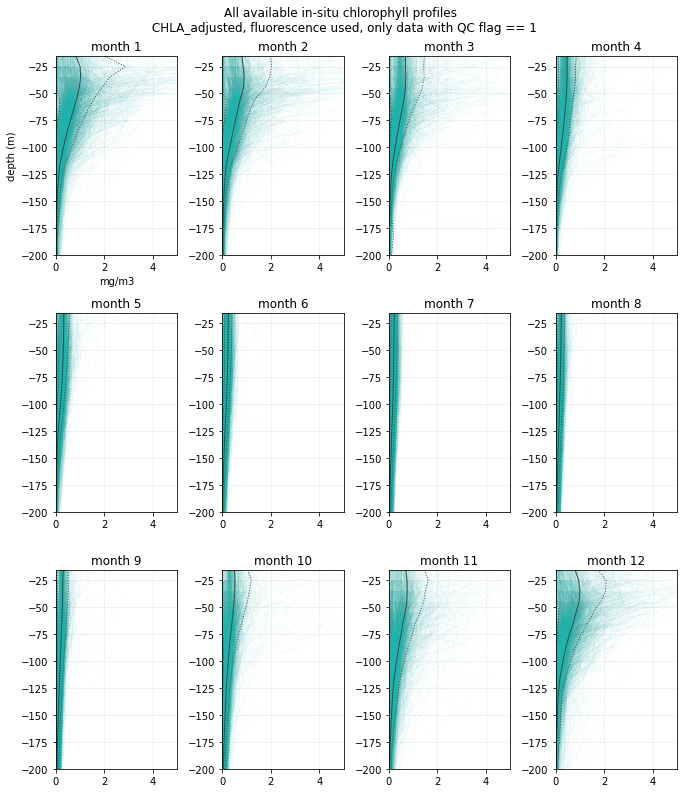

In [45]:
plt.rcParams.update({'font.size': 10})
font = {
'weight' : 'normal',
'size'   : 10}

plt.rc('font', **font)

fact = 0.8
fig, axs = plt.subplots(3,4, figsize=(12*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(1,13):
    tfilt = ((tmonth[:,0] == i) & (tlat[:,0] < -30))
    tchl = (tchla_adj[tfilt,:])
    chlm = np.nanmean(tchl, axis = 0)
    chlstd = np.nanstd(tchl, axis = 0)
    chl_up = chlm + chlstd
    chl_do = chlm - chlstd

    for c in range(0,len(tchl[:,0])):
        axs[i-1].plot(tchl[c,:],-tmask, alpha = 0.1, \
                      color = 'lightseagreen', linestyle = '-', linewidth = 0.2)
    axs[i-1].plot(chlm, -tmask, color = 'darkslategrey', linewidth = 1)
    axs[i-1].plot(chl_do, -tmask, linestyle = ':', color = 'darkslategrey', linewidth = 1)
    axs[i-1].plot(chl_up, -tmask, linestyle = ':', color = 'darkslategrey', linewidth = 1)
    #axs[i-1].fill_betweenx(-tmask, chl_do,chl_up, color = 'darkslategrey', alpha = 0.1)
        
for i in range(0,12):
    axs[i].set_ylim([-200,-15])
    axs[i].set_xlim([0,5])
    axs[i].grid(color = 'grey', linewidth = 0.5, alpha = 0.2)
    axs[i].set_title(f'month {i+1}')
axs[0].set_ylabel('depth (m)')
axs[0].set_xlabel('mg/m3')
    
plt.suptitle('All available in-situ chlorophyll profiles \n CHLA_adjusted, fluorescence used, only data with QC flag == 1')
plt.tight_layout()

# Plotting summer depth profiles, by latitude band (months 12, 1, 2) 

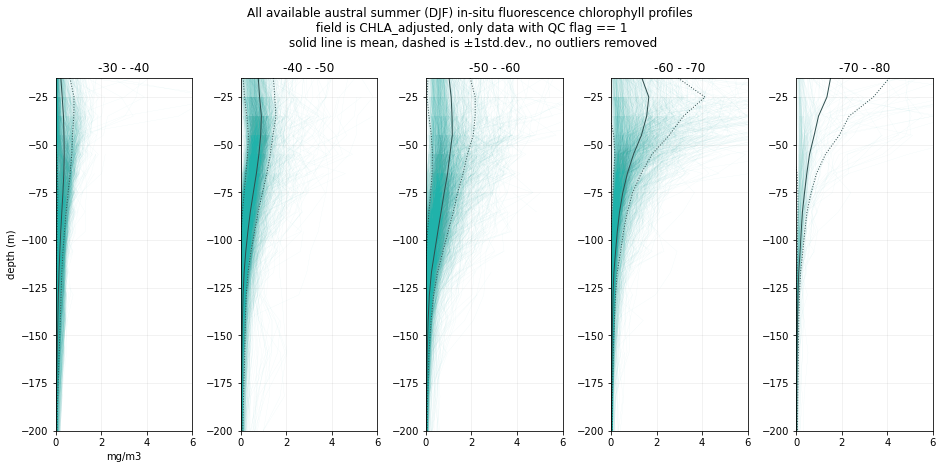

In [48]:
plt.rcParams.update({'font.size': 10})
font = {
'weight' : 'normal',
'size'   : 10}

plt.rc('font', **font)

fact = 1.1
fig, axs = plt.subplots(1,5, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(1,6):
    
    lat1 = -20 - (10*i)
    lat2 = lat1 - 10
    tit = (f'{lat1} - {lat2}')
    tfilt = (((tmonth[:,0] == 12) | (tmonth[:,0] == 1) | (tmonth[:,0] == 2) )  &\
             ((tlat[:,0] < lat1) &  (tlat[:,0] >= lat2)))
    tchl = (tchla_adj[tfilt,:])
    chlm = np.nanmean(tchl, axis = 0)
    chlstd = np.nanstd(tchl, axis = 0)
    chl_up = chlm + chlstd
    chl_do = chlm - chlstd

    for c in range(0,len(tchl[:,0])):
        axs[i-1].plot(tchl[c,:],-tmask, alpha = 0.1, \
                      color = 'lightseagreen', linestyle = '-', linewidth = 0.2)
    axs[i-1].plot(chlm, -tmask, color = 'darkslategrey', linewidth = 1)
    axs[i-1].plot(chl_do, -tmask, linestyle = ':', color = 'darkslategrey', linewidth = 1)
    axs[i-1].plot(chl_up, -tmask, linestyle = ':', color = 'darkslategrey', linewidth = 1)
    #axs[i-1].fill_betweenx(-tmask, chl_do,chl_up, color = 'darkslategrey', alpha = 0.1)
    axs[i-1].set_title(tit)     
for i in range(0,5):
    axs[i].set_ylim([-200,-15])
    axs[i].set_xlim([0,6])
    axs[i].grid(color = 'grey', linewidth = 0.5, alpha = 0.2)
    
axs[0].set_ylabel('depth (m)')
axs[0].set_xlabel('mg/m3')
    
plt.suptitle('All available austral summer (DJF) in-situ fluorescence chlorophyll profiles \n field is CHLA_adjusted, only data with QC flag == 1 \n solid line is mean, dashed is ±1std.dev., no outliers removed')
plt.tight_layout()

In [47]:
print('compute complete')

compute complete
